### This notebook compares kszx.Cosmology to hmvec.Cosmology 

This is a useful cross-check for bugs.

In order to run the notebook, you'll need to have the following installed:
 - kszx (https://github.com/kmsmith137/kszx)
 - hmvec (https://github.com/simonsobs/hmvec)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Import kszx and create kszx.Cosmology object

In [2]:
import kszx
cosmo = kszx.Cosmology('hmvec')   # use same cosmological params as hmvec

Initializing 'hmvec' cosmology
Running CAMB
Done running CAMB [0.8164494037628174 seconds]


### Import hmvec and create hmvec.cosmology.Cosmology instance
Note: I'd like to use `engine='class'` here, in order to compare CAMB vs CLASS, and in order to compare `kszx.Cosmology.frsd()` with `hmvec.Cosmology.get_growth_rate_f()` (which is implemented for CLASS but not CAMB). However I had trouble compiling CLASS on my machine (cython errors that I didn't know how to fix).

In [3]:
import hmvec
hmcosmo = hmvec.cosmology.Cosmology()

In [4]:
zvec = np.linspace(0,5,100)
kvec = kszx.utils.logspace(1.0e-5, 100.0, 300)
klgvec = kszx.utils.logspace(1.0e-5, 0.1, 300)
zlist = [ 0.0, 1.0, 3.0, 5.0 ]

### Compare H(z)

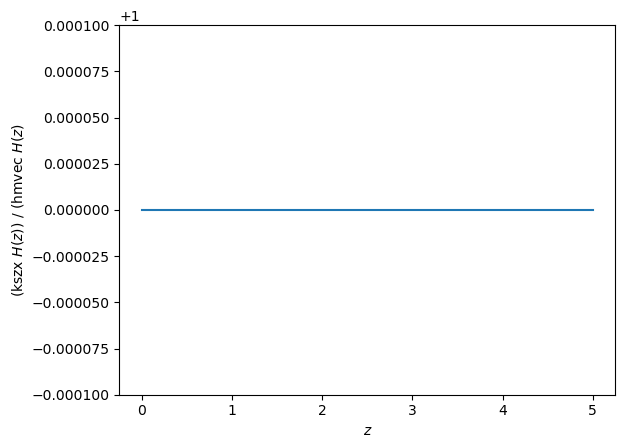

In [5]:
plt.plot(zvec, cosmo.H(z=zvec)/hmcosmo.h_of_z(zvec))
plt.xlabel(r'$z$')
plt.ylabel(r'(kszx $H(z)$) / (hmvec $H(z)$')
plt.ylim(0.9999, 1.0001)
plt.show()

### Compare chi(z)

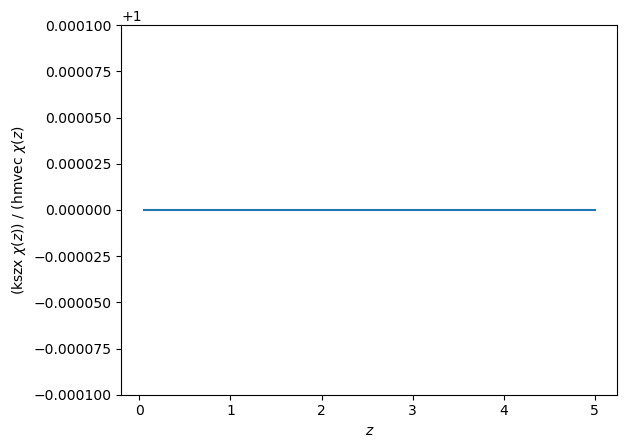

In [6]:
plt.plot(zvec[1:], cosmo.chi(z=zvec[1:])/hmcosmo.comoving_radial_distance(zvec[1:]))
plt.xlabel(r'$z$')
plt.ylabel(r'(kszx $\chi(z)$) / (hmvec $\chi(z)$')
plt.ylim(0.9999, 1.0001)
plt.show()

### Compare z(chi)

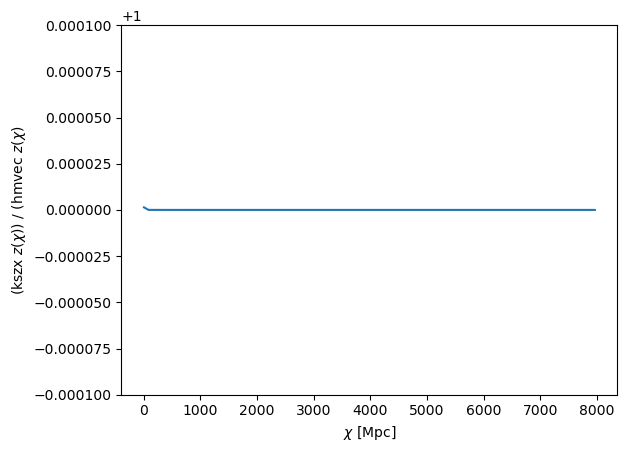

In [7]:
chivec = np.linspace(1.0, cosmo.chi(z=5), 100)
plt.plot(chivec, cosmo.z(chi=chivec) / hmcosmo.redshift_at_comoving_radial_distance(chivec))
plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'(kszx $z(\chi)$) / (hmvec $z(\chi)$')
plt.ylim(0.9999, 1.0001)
plt.show()

### Compare growth function D(z), with two choices of normalization

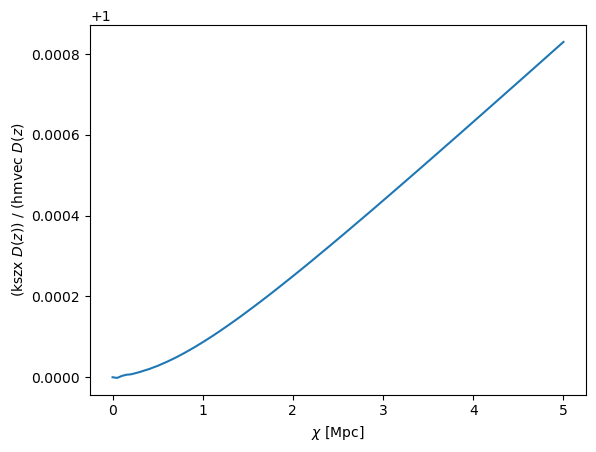

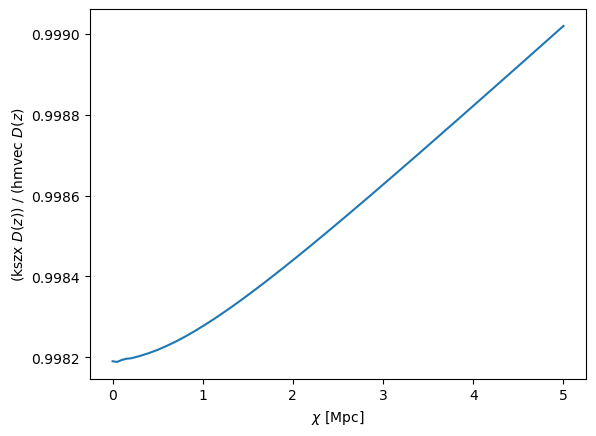

In [8]:
plt.plot(zvec, cosmo.D(z=zvec,z0norm=True) / hmcosmo.D_growth(a=1./(1+zvec), type='z0norm'))
plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'(kszx $D(z)$) / (hmvec $D(z)$')
# plt.ylim(0.9999, 1.0001)
plt.show()

plt.plot(zvec, cosmo.D(z=zvec,z0norm=False) / hmcosmo.D_growth(a=1./(1+zvec), type='anorm'))
plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'(kszx $D(z)$) / (hmvec $D(z)$')
# plt.ylim(0.9999, 1.0001)
plt.show()

### Compare P_lin(k,z)

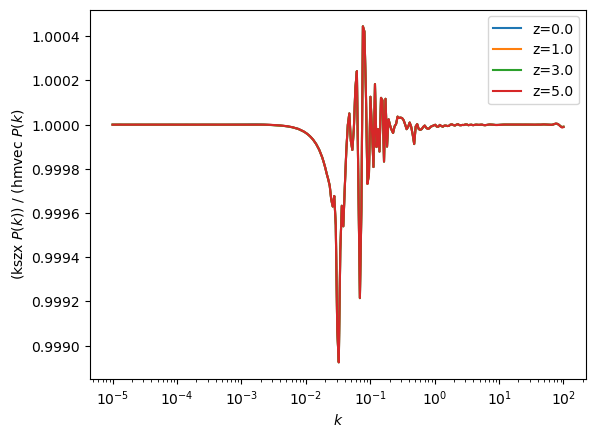

In [9]:
pkz = cosmo.Plin(k=kvec, z=zlist, kzgrid=True)
hmpkz = hmcosmo.P_lin_slow(ks=kvec, zs=zlist).T   # note transpose 

for iz,z in enumerate(zlist):
    plt.semilogx(kvec, pkz[:,iz] / hmpkz[:,iz], label=f'z={z}')
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'(kszx $P(k)$) / (hmvec $P(k)$')
plt.show()

### Inspect f_rsd(z)

It's not straightforward to get f(z) from CAMB, so we compute it using the fitting function Omega_m(z)^(5/9).
As a rough test of this fitting function, we estimate f(z) = d(log D)/d(log a) by finite difference, and compare.

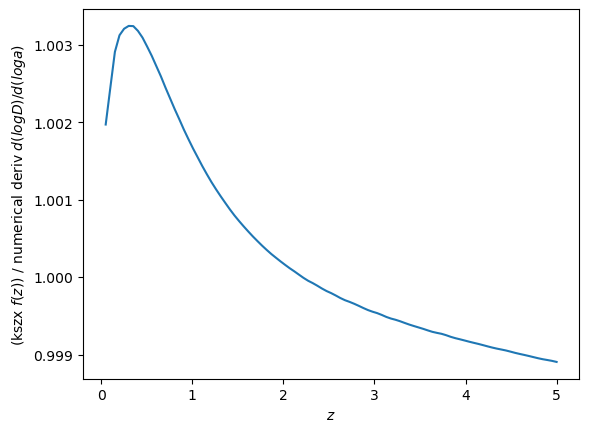

In [10]:
def f_diff(z):
    """Estimate f=d(log D)/d(log a) by finite difference."""
    z = np.array(z)
    dloga = 0.01
    a = 1./(1+z)
    a_plus = a * np.exp(dloga)
    a_minus = a * np.exp(-dloga)
    D_plus = cosmo.D(z=(1/a_plus-1), z0norm=False)
    D_minus = cosmo.D(z=(1/a_minus-1), z0norm=False)
    return (np.log(D_plus) - np.log(D_minus)) / (2*dloga)

plt.plot(zvec[1:], f_diff(zvec[1:])/cosmo.frsd(z=zvec[1:]))
plt.xlabel(r'$z$')
plt.ylabel('(kszx $f(z)$) / numerical deriv $d(log D)/d(log a)$')
plt.show()

### Compare alpha(k,z)

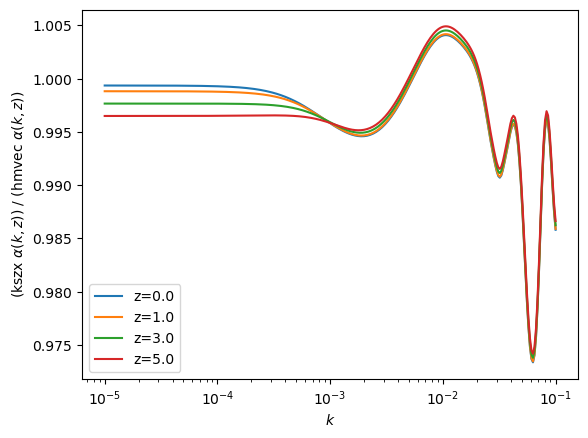

In [11]:
def hm_alpha(k,z):
    """Vectorized in k, but not z."""
    # final alpha(k,z) should be independent of these choices
    bg, fnl, deltac = 2, 10**6, 1.42
    btot = hmcosmo.bias_fnl(bg, fnl, z, k, deltac)
    return 2 * deltac * (bg-1) * fnl / (btot - bg) 

alpha_kz = cosmo.alpha(k=klgvec, z=zlist, kzgrid=True)

for iz,z in enumerate(zlist):
    hma = hm_alpha(klgvec, z)
    plt.semilogx(klgvec, alpha_kz[:,iz]/hma, label=f'z={z}')

plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'(kszx $\alpha(k,z)$) / (hmvec $\alpha(k,z)$)')
plt.show()

### Just curious: how scale-dependent is the growth?

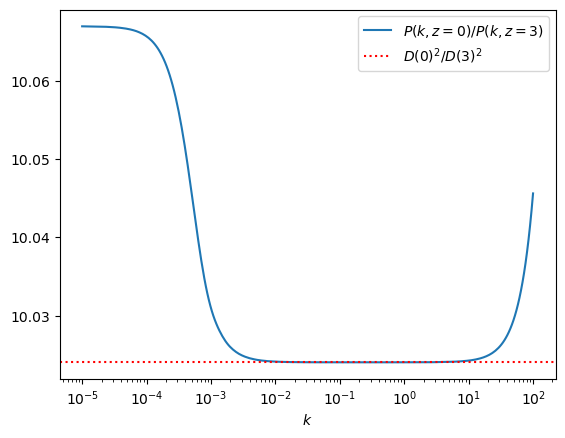

In [12]:
plt.semilogx(kvec, cosmo.Plin(k=kvec,z=0)/cosmo.Plin(k=kvec,z=3), label=r'$P(k,z=0)/P(k,z=3)$')
plt.axhline(1/cosmo.D(z=3,z0norm=True)**2, color='r', ls=':', label=r'$D(0)^2/D(3)^2$')
plt.legend(loc='upper right')
plt.xlabel(r'$k$')
plt.show()

### Just curious: how good is the approximation P(k) ~ k at low k?

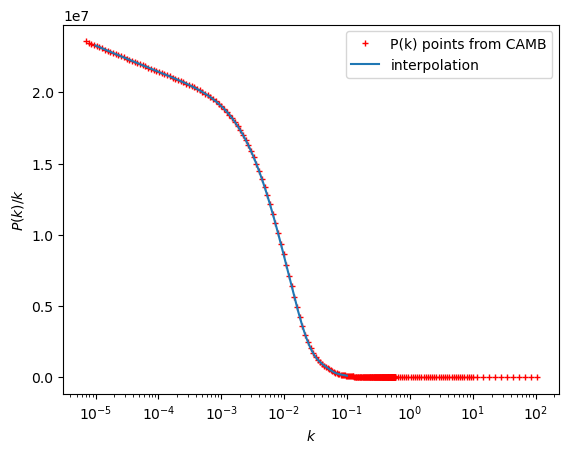

In [13]:
plt.semilogx(cosmo._plin_k, cosmo._plin_pzk[0]/cosmo._plin_k, marker='+', 
             markersize=5, ls='none', color='red', label='P(k) points from CAMB')
plt.semilogx(klgvec, cosmo.Plin_z0(klgvec)/klgvec, label='interpolation')
plt.legend(loc='upper right')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)/k$')
plt.show()